In [2]:
import librosa

In [3]:
import matplotlib.pyplot as plt
import librosa.display

In [4]:
music_arry, sample_rate = librosa.load('night-cat-fight-26307.mp3')

In [13]:
import numpy as np

def framing(sig, fs=22050, win_len=2, win_hop=0.01):
    
    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step
    # Make sure that we have at least 1 frame+
    num_frames = np.abs(signal_length - frames_overlap) // np.abs(frame_length - frames_overlap)
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    # Pad Signal to make sure that all frames have equal number of samples
    # without truncating any samples from the original signal
    if rest_samples != 0:
        pad_signal_length = int(frame_step - rest_samples)
        z = np.zeros((pad_signal_length))
        pad_signal = np.append(sig, z)
        num_frames += 1
    else:
        pad_signal = sig
    # make sure to use integers as indices
    frame_length = int(frame_length)
    frame_step = int(frame_step)
    num_frames = int(num_frames)
    # compute indices
    idx1 = np.tile(np.arange(0, frame_length), (num_frames, 1))
    idx2 = np.tile(np.arange(0, num_frames * frame_step, frame_step),(frame_length, 1)).T
    indices = idx1 + idx2
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

In [14]:
frames = framing(music_arry)

In [15]:
print(len(frames))

5516


(-1.0, 1.0)

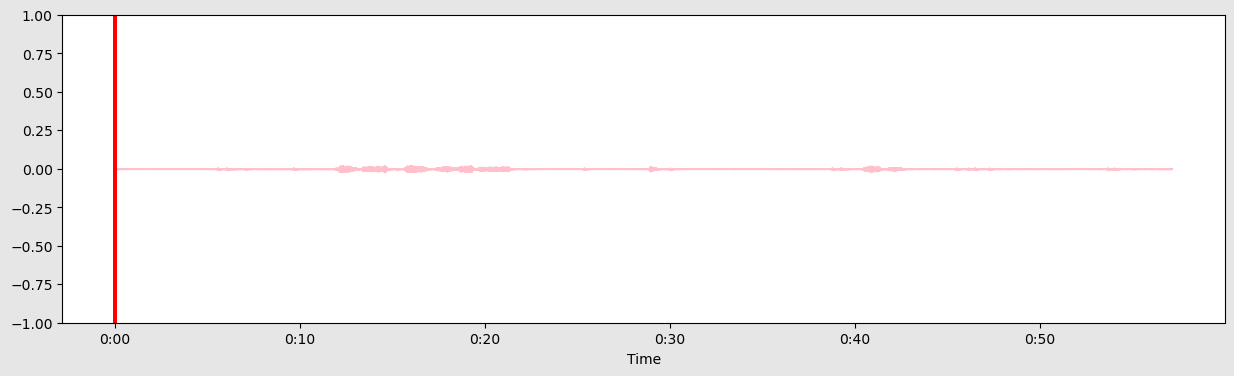

In [16]:
plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
librosa.display.waveshow(music_arry, sr=sample_rate, color='pink')
plt.vlines(frames[50], -1, 1, color='r')
plt.ylim(-1,1)

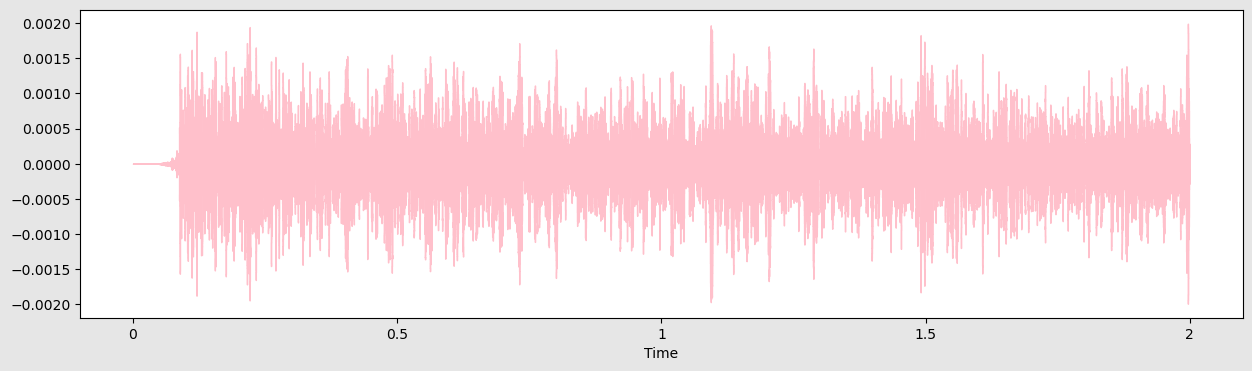

In [22]:
plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
librosa.display.waveshow(frames[1], sr=sample_rate, color='pink')

In [21]:
import IPython.display as ipd
ipd.display(ipd.Audio(frames[55], rate=sample_rate))

In [16]:
start=0
timing = []
for f in frames:
    time_interval = str(start)+'-'+str(round(start+(1/60)))
    timing.append(time_interval)
    start+=(1/60)
    
    #FEATURES EXTRACTION
    

In [10]:
x = librosa.stft(music_arry)
xdb = librosa.amplitude_to_db(abs(x))

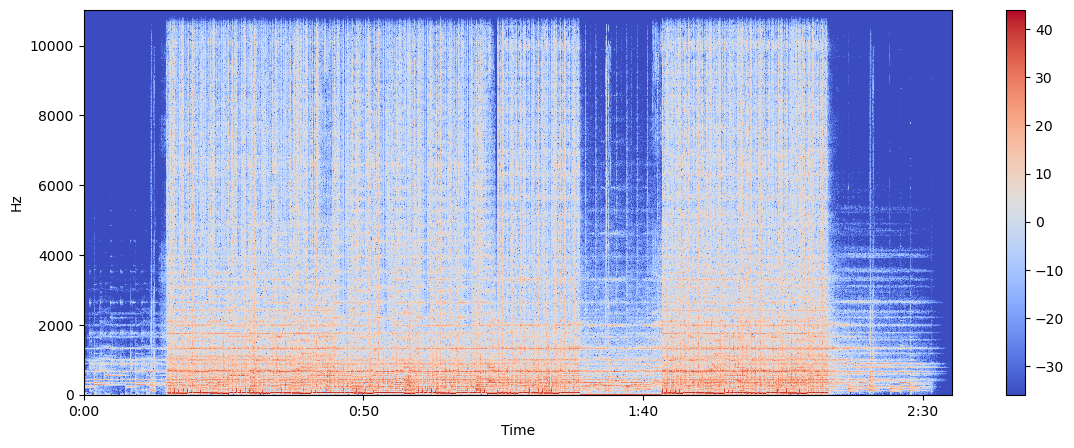

In [11]:
plt.figure(figsize=(14,5))
librosa.display.specshow(xdb,sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [12]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [59]:
output = removeNoise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip,verbose=True,visual=True)

NameError: name 'audio_clip_band_limited' is not defined

In [60]:
tempo, beat_frames = librosa.beat.beat_track(y=music_arry, sr=sample_rate)
print(tempo)

129.19921875


In [65]:
beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)

In [71]:
beat_times.shape

(316,)

(-1.0, 1.0)

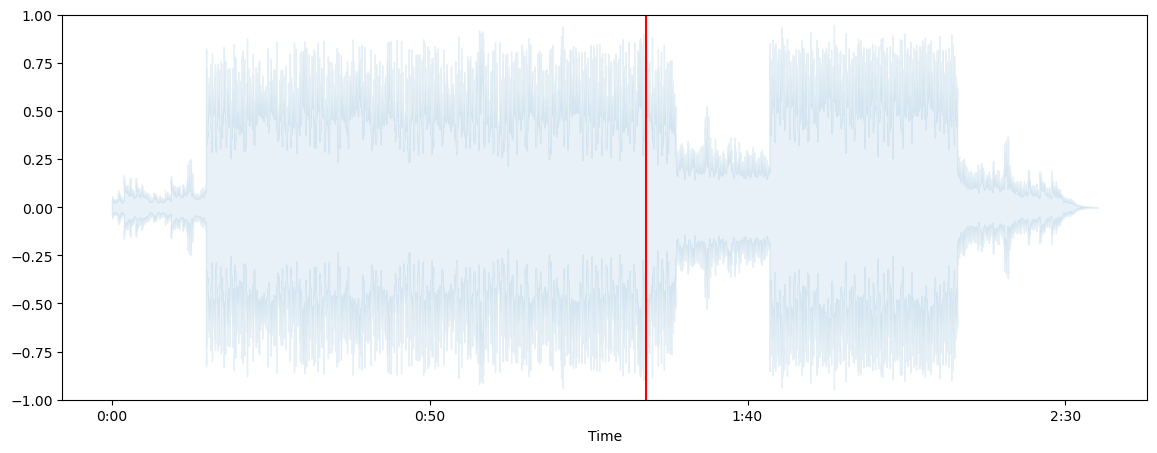

In [76]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(music_arry, alpha=0.1)
plt.vlines(beat_frames[0], -1, 1, color='r')
plt.ylim(-1,1)

In [77]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(beat_times[0], alpha=0.1)
plt.vlines(beat_times, -1, 1, color='r')
plt.ylim(-1,1)

ParameterError: Audio data must be of type numpy.ndarray

<Figure size 1400x500 with 0 Axes>